# Do any adult males survive? XGBoost will tell us!
There are 245 adult males in the Titanic test dataset. By reviewing all the top models on Kaggle, we see that everyone predicts that all adult males die. Is it possible to find at least 1 adult male that lived? If we can correctly predict the survival of any adult males, we can combine those predictions with a previously top scoring model, such as the WCG model, and have the most accurate Titanic model ever!   
![tree12](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/tree12.jpeg)  
  
The WCG (woman-child-group) model (displayed in yellow above) was first described [here][1] and improved upon [here][2]. It was first implemented using only Name and scored 82%. Adding Ticket, Fare, and Pclass increased it's score to 83%. Then the [Mega Model][3] showed that there are patterns in the non-WCG passengers. This kernel finds those patterns and scores 85%.
![tree12](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/xgb.jpeg)
## Explore adult males survival with XGBoost
First we'll load in the Titanic dataset and impute missing Age and Fare. Next we'll engineer two new variables, x1 = Fare / (Ticket Frequency * 10), and x2 = Parch + SibSp + 1 + (Age / 70). Reducing the feature space to 2 dimensions allows us to visualize everything.  
  
[1]:https://www.kaggle.com/cdeotte/titanic-using-name-only-0-81818
[2]:https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210
[3]:https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210

data3 shape: (537, 4)
y NaNs: 0
y values: {1.0: 451, 0.0: 86}


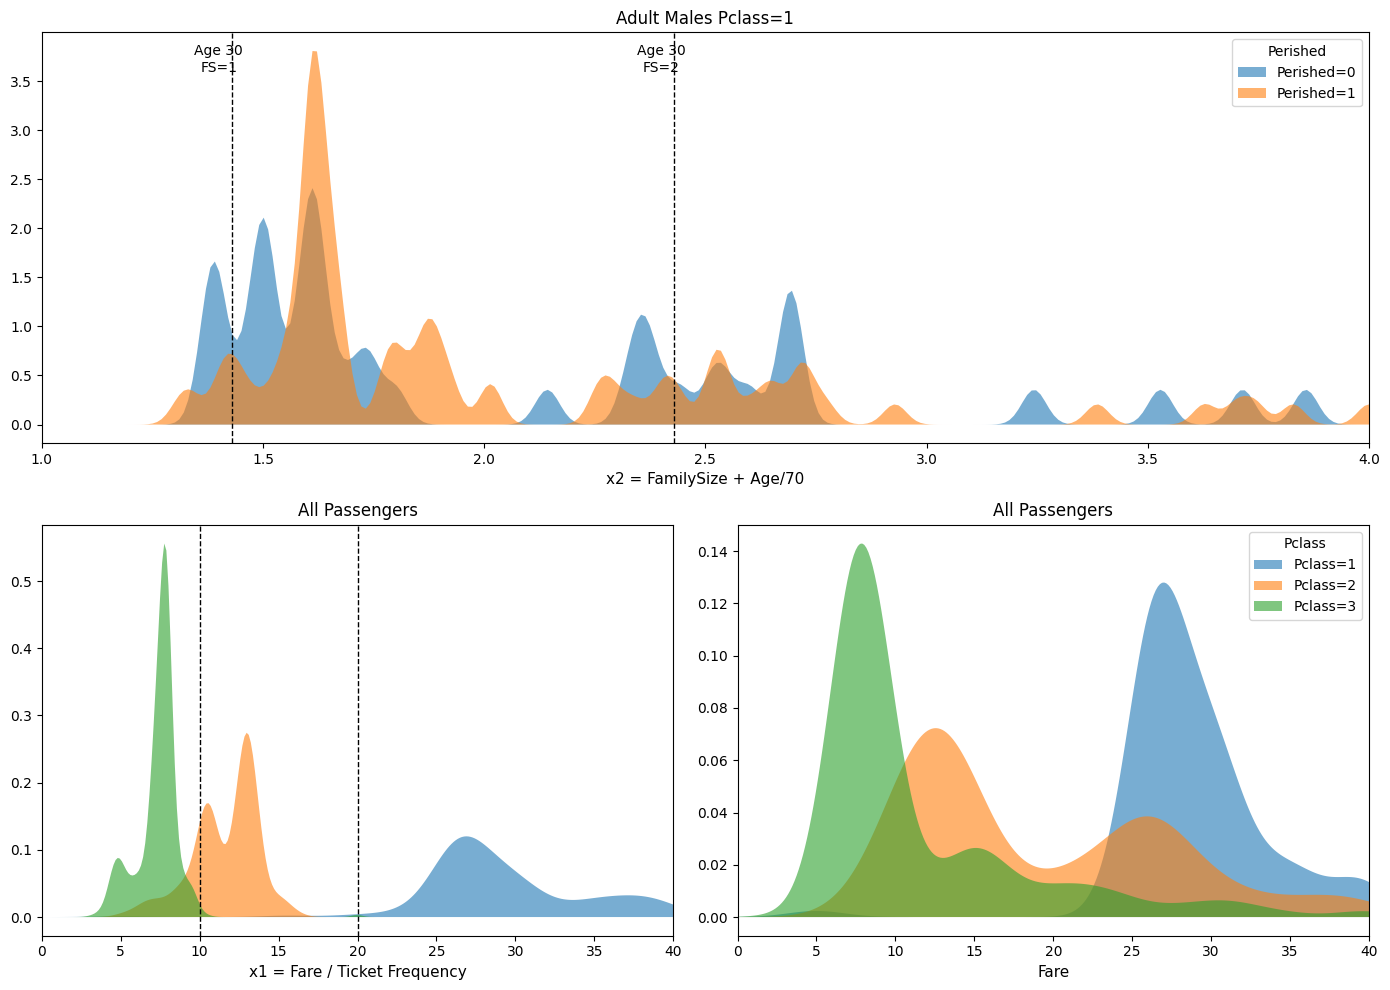

XGBoosting begun...


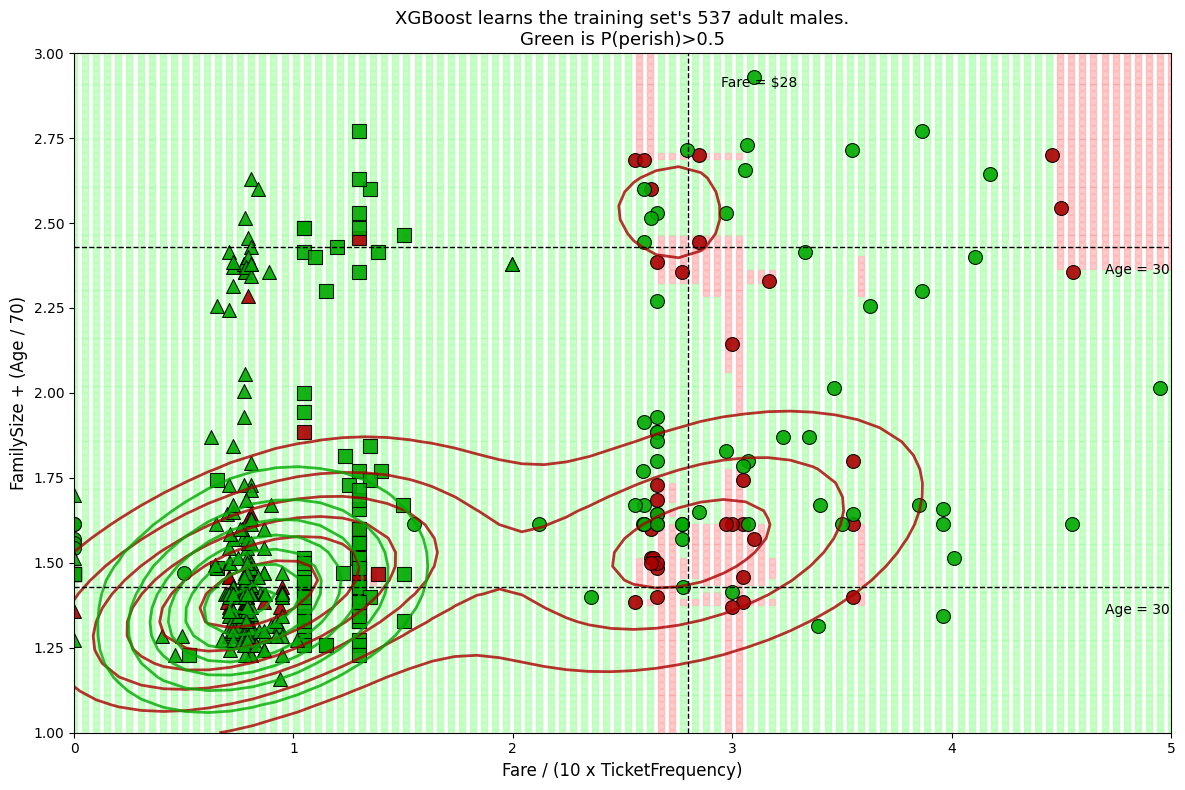


s (test): 100 samples, s2 (train): 437 samples
予測確率の範囲: 0.0802 - 0.9890


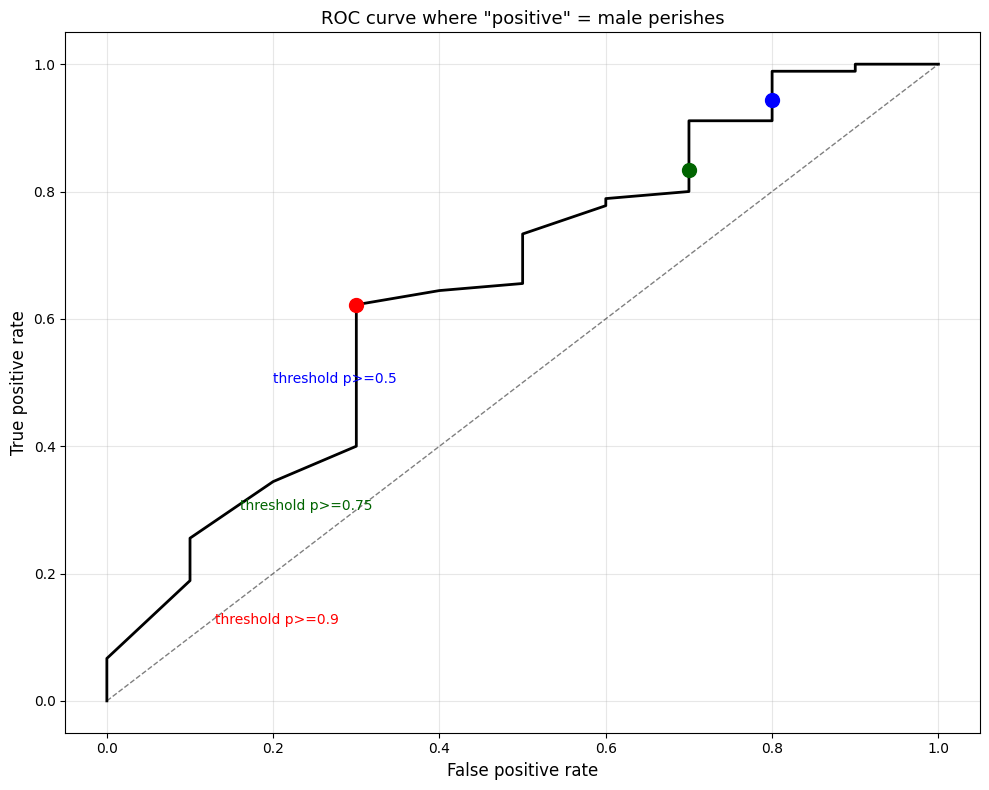


Area under ROC = 0.671111


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.stats import gaussian_kde

# ===== 1. データ前処理 =====
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# Perished対応
test['Perished'] = np.nan
data = pd.concat([train, test], ignore_index=True)

# Title作成
data['Title'] = 'man'
data.loc[data['Name'].str.contains('Master', na=False), 'Title'] = 'boy'
data.loc[data['Sex'] == 'female', 'Title'] = 'woman'

# ===== Age補完（rpart互換性問題対応） =====
# rpartのデフォルト設定を再現
from sklearn.tree import DecisionTreeRegressor

data_for_age = data.copy()
# Rのfactorはordered=Falseのカテゴリ型に相当
data_for_age['Title_cat'] = pd.Categorical(data_for_age['Title'], 
                                             categories=['boy', 'man', 'woman'],
                                             ordered=False).codes

age_not_na = data_for_age['Age'].notna()
if data['Age'].isna().sum() > 0:
    # rpartのデフォルト設定：cp=0.01, minsplit=20, minbucket=7
    # sklearnで近似：min_samples_split=20, min_samples_leaf=7, ccp_alpha=0.01
    age_model = DecisionTreeRegressor(
        random_state=0,  # 注意：Rのset.seed()と完全一致しない
        min_samples_split=20,
        min_samples_leaf=7,
        max_depth=None
    )
    age_model.fit(
        data_for_age.loc[age_not_na, ['Title_cat', 'Pclass', 'SibSp', 'Parch']],
        data_for_age.loc[age_not_na, 'Age']
    )
    age_na = data['Age'].isna()
    data.loc[age_na, 'Age'] = age_model.predict(
        data_for_age.loc[age_na, ['Title_cat', 'Pclass', 'SibSp', 'Parch']]
    )

# ===== Fare補完 =====
data_for_fare = data.copy()
data_for_fare['Title_cat'] = pd.Categorical(data_for_fare['Title'],
                                              categories=['boy', 'man', 'woman'],
                                              ordered=False).codes
data_for_fare['Sex_cat'] = pd.Categorical(data_for_fare['Sex'],
                                            categories=['female', 'male'],
                                            ordered=False).codes
# Embarkedの欠損は'S'で埋める（Rの挙動）
data_for_fare['Embarked_filled'] = data_for_fare['Embarked'].fillna('S')
data_for_fare['Embarked_cat'] = pd.Categorical(data_for_fare['Embarked_filled'],
                                                 categories=['C', 'Q', 'S'],
                                                 ordered=False).codes

fare_not_na = data_for_fare['Fare'].notna()
if data['Fare'].isna().sum() > 0:
    fare_model = DecisionTreeRegressor(
        random_state=0,
        min_samples_split=20,
        min_samples_leaf=7,
        max_depth=None
    )
    fare_model.fit(
        data_for_fare.loc[fare_not_na, ['Title_cat', 'Pclass', 'Embarked_cat', 'Sex_cat', 'Age']],
        data_for_fare.loc[fare_not_na, 'Fare']
    )
    fare_na = data['Fare'].isna()
    data.loc[fare_na, 'Fare'] = fare_model.predict(
        data_for_fare.loc[fare_na, ['Title_cat', 'Pclass', 'Embarked_cat', 'Sex_cat', 'Age']]
    )

# 特徴量作成
data['TicketFreq'] = data.groupby('Ticket')['Ticket'].transform('count')
data['FareAdj'] = data['Fare'] / data['TicketFreq']
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

# data2, data3作成
data2 = data[(data['PassengerId'] <= 891) & (data['Title'] == 'man')].copy()

data3 = pd.DataFrame({
    'y': data2['Perished'].values,
    'x1': data2['Fare'].values / (data2['TicketFreq'].values * 10),
    'x2': (data2['SibSp'].values + data2['Parch'].values + 1) + (data2['Age'].values / 70),
    'Pclass': data2['Pclass'].values
})

print(f"data3 shape: {data3.shape}")
print(f"y NaNs: {data3['y'].isna().sum()}")
print(f"y values: {data3['y'].value_counts().to_dict()}")

# ===== 2. 可視化 =====
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# g3
ax1 = fig.add_subplot(gs[0, :])
subset = data[(data['Perished'].notna()) & 
              (data['Title'] == 'man') & 
              (data['Pclass'] == 1) & 
              (data['FamilySize'] < 4)].copy()
subset['x2'] = subset['FamilySize'] + subset['Age'] / 70

for perished in [0, 1]:
    subset_perished = subset[subset['Perished'] == perished]['x2'].values
    if len(subset_perished) > 1:
        kde = gaussian_kde(subset_perished, bw_method=0.04)
        x_range = np.linspace(1, 4, 300)
        density = kde(x_range)
        ax1.fill_between(x_range, density, alpha=0.6, label=f'Perished={int(perished)}')

ax1.axvline(x=1.43, linestyle='--', color='black', linewidth=1)
ax1.axvline(x=2.43, linestyle='--', color='black', linewidth=1)
ax1.text(1.4, ax1.get_ylim()[1]*0.9, 'Age 30\nFS=1', ha='center', fontsize=10)
ax1.text(2.4, ax1.get_ylim()[1]*0.9, 'Age 30\nFS=2', ha='center', fontsize=10)
ax1.set_xlim(1, 4)
ax1.set_xlabel('x2 = FamilySize + Age/70', fontsize=11)
ax1.set_title('Adult Males Pclass=1', fontsize=12)
ax1.legend(title='Perished')

# g1
ax2 = fig.add_subplot(gs[1, 0])
subset_fare = data[(data['FareAdj'] > 0) & (data['FareAdj'] < 40)]
for pclass in [1, 2, 3]:
    subset_pclass = subset_fare[subset_fare['Pclass'] == pclass]['FareAdj'].values
    if len(subset_pclass) > 1:
        kde = gaussian_kde(subset_pclass)
        x_range = np.linspace(0, 40, 300)
        density = kde(x_range)
        ax2.fill_between(x_range, density, alpha=0.6)

ax2.axvline(x=10, linestyle='--', color='black', linewidth=1)
ax2.axvline(x=20, linestyle='--', color='black', linewidth=1)
ax2.set_xlim(0, 40)
ax2.set_xlabel('x1 = Fare / Ticket Frequency', fontsize=11)
ax2.set_title('All Passengers', fontsize=12)

# g2
ax3 = fig.add_subplot(gs[1, 1])
subset_fare2 = data[(data['Fare'] > 0) & (data['Fare'] < 40)]
for pclass in [1, 2, 3]:
    subset_pclass = subset_fare2[subset_fare2['Pclass'] == pclass]['Fare'].values
    if len(subset_pclass) > 1:
        kde = gaussian_kde(subset_pclass)
        x_range = np.linspace(0, 40, 300)
        density = kde(x_range)
        ax3.fill_between(x_range, density, alpha=0.6, label=f'Pclass={pclass}')

ax3.set_xlim(0, 40)
ax3.set_xlabel('Fare', fontsize=11)
ax3.set_ylabel('', fontsize=11)
ax3.set_title('All Passengers', fontsize=12)
ax3.legend(title='Pclass')

plt.tight_layout()
plt.show()

# ===== 3. XGBoost分類領域 =====
x1s = np.linspace(0, 5, 100)
x2s = np.linspace(1, 3, 100)
x1_grid = np.repeat(x1s, 100)
x2_grid = np.tile(x2s, 100)
g = pd.DataFrame({'x1': x1_grid, 'x2': x2_grid})

# XGBoostパラメータ（Rのデフォルト挙動に注意）
param = {
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'max_depth': 5,
    'eta': 0.1,
    'gamma': 0.1,
    'colsample_bytree': 1.0,
    'min_child_weight': 1,
    'subsample': 1.0,  # Rのデフォルト
    'tree_method': 'auto',  # 注意：exactにすると遅いが再現性高い
    'seed': 0  # random_stateの代わり
}

print('XGBoosting begun...')
dtrain_full = xgb.DMatrix(data3[['x1', 'x2']].values, label=data3['y'].values)
xgb_model = xgb.train(
    params=param,
    dtrain=dtrain_full,
    num_boost_round=500,
    verbose_eval=100
)

dgrid = xgb.DMatrix(g[['x1', 'x2']].values)
p_grid = xgb_model.predict(dgrid)
g['y'] = np.where(p_grid > 0.5, 1, 0)

plot_data = data3[(data3['x1'] < 5) & (data3['x2'] < 3)].copy()

fig, ax = plt.subplots(figsize=(12, 8))

colors_tile = {0: '#FF9999', 1: '#99FF99'}
for y_val in [0, 1]:
    mask = g['y'] == y_val
    ax.scatter(g.loc[mask, 'x1'], g.loc[mask, 'x2'], 
               c=colors_tile[y_val], s=15, alpha=0.5, marker='s')

colors_line = {0: '#AA0000', 1: '#00AA00'}
for y_val in [0, 1]:
    subset = plot_data[plot_data['y'] == y_val]
    if len(subset) > 5:
        try:
            kde = gaussian_kde(subset[['x1', 'x2']].values.T)
            x1_kde = np.linspace(0, 5, 50)
            x2_kde = np.linspace(1, 3, 50)
            X1_kde, X2_kde = np.meshgrid(x1_kde, x2_kde)
            positions = np.vstack([X1_kde.ravel(), X2_kde.ravel()])
            Z = kde(positions).reshape(X1_kde.shape)
            ax.contour(X1_kde, X2_kde, Z, colors=colors_line[y_val], linewidths=2, alpha=0.8)
        except:
            pass

markers = {1: 'o', 2: 's', 3: '^'}
for pclass in [1, 2, 3]:
    for y_val in [0, 1]:
        subset = plot_data[(plot_data['Pclass'] == pclass) & (plot_data['y'] == y_val)]
        if len(subset) > 0:
            ax.scatter(subset['x1'], subset['x2'], 
                      c=colors_line[y_val], 
                      marker=markers[pclass],
                      s=100, 
                      edgecolors='black',
                      linewidths=0.8,
                      alpha=0.9)

ax.axvline(x=2.8, linestyle='--', color='black', linewidth=1)
ax.axhline(y=1.43, linestyle='--', color='black', linewidth=1)
ax.axhline(y=2.43, linestyle='--', color='black', linewidth=1)

ax.text(2.95, 2.9, 'Fare = $28', fontsize=10)
ax.text(4.7, 2.35, 'Age = 30', fontsize=10)
ax.text(4.7, 1.35, 'Age = 30', fontsize=10)

ax.set_xlim(0, 5)
ax.set_ylim(1, 3)
ax.set_xlabel('Fare / (10 x TicketFrequency)', fontsize=12)
ax.set_ylabel('FamilySize + (Age / 70)', fontsize=12)
ax.set_title("XGBoost learns the training set's 537 adult males.\nGreen is P(perish)>0.5", fontsize=13)

plt.tight_layout()
plt.show()

# ===== 4. ROC曲線（完全互換版） =====
# 乱数シード：300
np.random.seed(300)

if data3['y'].isna().sum() > 0:
    data3_work = data3.dropna(subset=['y']).reset_index(drop=True)
else:
    data3_work = data3.reset_index(drop=True)

n = len(data3_work)
all_indices = np.arange(n)

s = np.random.choice(all_indices, size=100, replace=False)
s2 = np.setdiff1d(all_indices, s)

print(f"\ns (test): {len(s)} samples, s2 (train): {len(s2)} samples")

# XGBoostパラメータ（ROC用）
param_roc = {
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'max_depth': 5,
    'eta': 0.1,
    'gamma': 0.1,
    'colsample_bytree': 1.0,
    'min_child_weight': 1,
    'subsample': 1.0,
    'tree_method': 'auto',
    'seed': 0
}

X_train = data3_work.loc[s2, ['x1', 'x2']].values
y_train = data3_work.loc[s2, 'y'].values

dtrain = xgb.DMatrix(X_train, label=y_train)

xgb_model_roc = xgb.train(
    params=param_roc,
    dtrain=dtrain,
    num_boost_round=500,
    verbose_eval=False
)

X_test = data3_work.loc[s, ['x1', 'x2']].values
dtest = xgb.DMatrix(X_test)
p = xgb_model_roc.predict(dtest)

print(f"予測確率の範囲: {p.min():.4f} - {p.max():.4f}")

data3_work['y2'] = np.nan

# ROC計算（浮動小数点精度対応）
roc = pd.DataFrame({
    'TN': np.repeat(0, 102),
    'FP': np.repeat(0, 102),
    'FN': np.repeat(0, 102),
    'TP': np.repeat(0, 102),
    'FPR': np.repeat(0.0, 102),
    'TPR': np.repeat(0.0, 102)
})
# 浮動小数点誤差対応：np.round使用
roc.index = np.round(np.arange(0, 1.02, 0.01), 2)

for i in range(1, 103):
    threshold = (i - 1) / 100
    
    y_pred = np.where(p < threshold, 0, 1)
    data3_work.loc[s, 'y2'] = y_pred
    
    y_all = data3_work['y'].values
    y2_all = data3_work['y2'].values
    
    TP = np.sum((y_all == 1) & (y2_all == 1))
    TN = np.sum((y_all == 0) & (y2_all == 0))
    FP = np.sum((y_all == 0) & (y2_all == 1))
    FN = np.sum((y_all == 1) & (y2_all == 0))
    
    roc.iloc[i-1, roc.columns.get_loc('TP')] = TP
    roc.iloc[i-1, roc.columns.get_loc('TN')] = TN
    roc.iloc[i-1, roc.columns.get_loc('FP')] = FP
    roc.iloc[i-1, roc.columns.get_loc('FN')] = FN
    
    if (FP + TN) > 0:
        roc.iloc[i-1, roc.columns.get_loc('FPR')] = FP / (FP + TN)
    if (TP + FN) > 0:
        roc.iloc[i-1, roc.columns.get_loc('TPR')] = TP / (TP + FN)

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(roc['FPR'], roc['TPR'], linewidth=2, color='black')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)

ax.plot(roc.iloc[90]['FPR'], roc.iloc[90]['TPR'], 'o', markersize=10, color='red')
ax.text(0.13, 0.12, 'threshold p>=0.9', color='red', fontsize=10)

ax.plot(roc.iloc[75]['FPR'], roc.iloc[75]['TPR'], 'o', markersize=10, color='darkgreen')
ax.text(0.16, 0.30, 'threshold p>=0.75', color='darkgreen', fontsize=10)

ax.plot(roc.iloc[50]['FPR'], roc.iloc[50]['TPR'], 'o', markersize=10, color='blue')
ax.text(0.20, 0.5, 'threshold p>=0.5', color='blue', fontsize=10)

ax.set_xlabel('False positive rate', fontsize=12)
ax.set_ylabel('True positive rate', fontsize=12)
ax.set_title('ROC curve where "positive" = male perishes', fontsize=13)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

area = 0
for i in range(1, 102):
    area = area + roc.iloc[i-1]['TPR'] * (roc.iloc[i-1]['FPR'] - roc.iloc[i]['FPR'])

print(f'\nArea under ROC = {area:.6f}')

data3 shape: (537, 4)
y NaNs: 0


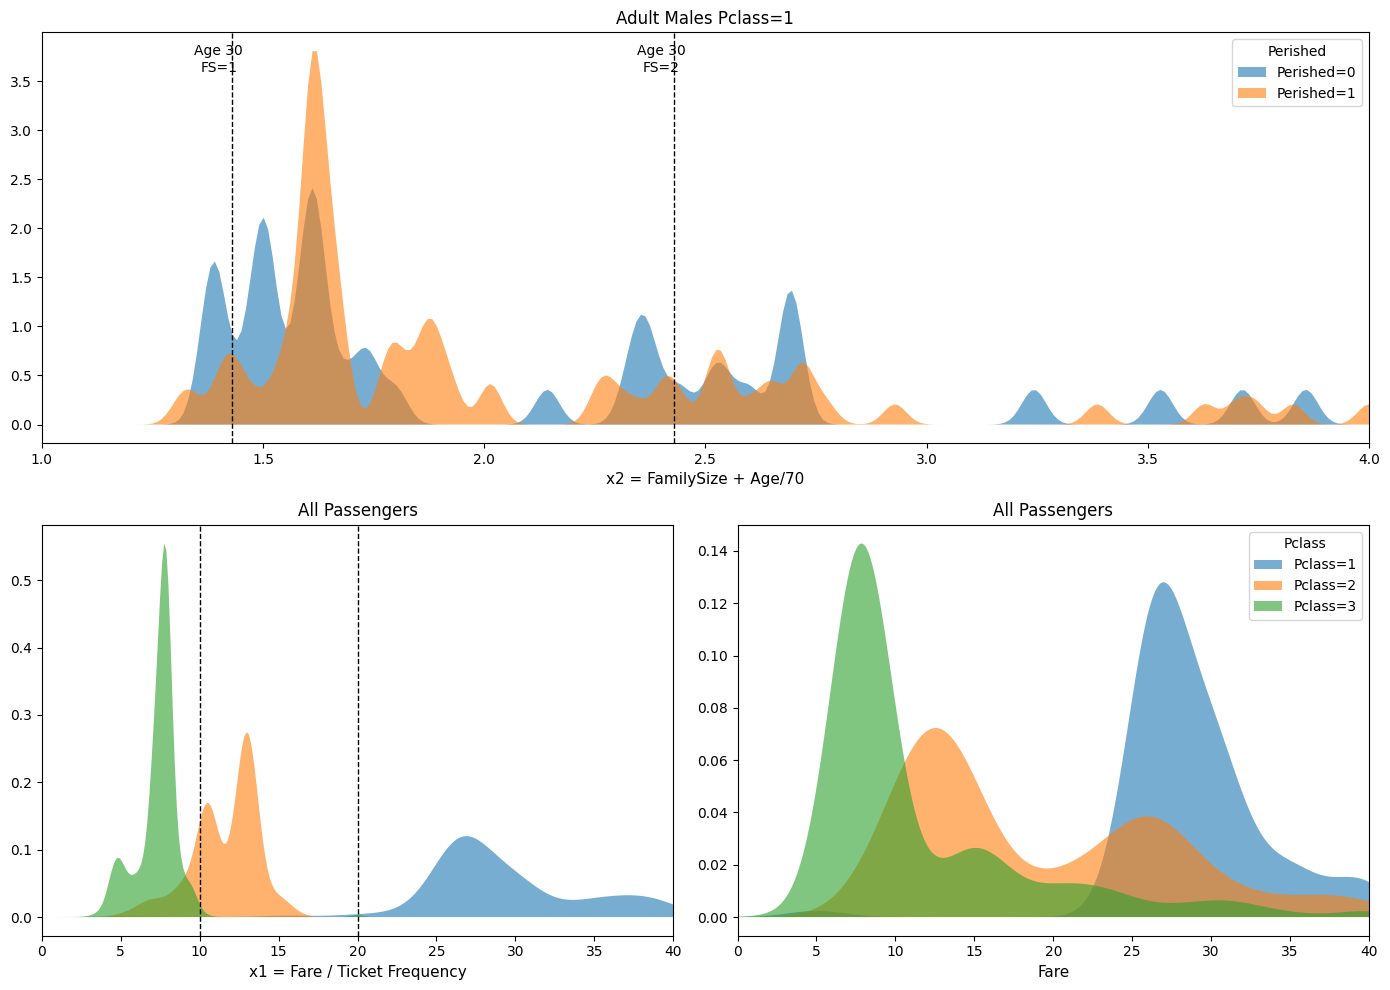

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# データ読み込み
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# Perishedコンペ対応：test$Perished <- NA; data <- rbind(train,test)
test['Perished'] = np.nan
data = pd.concat([train, test], ignore_index=True)

# engineer person type
data['Title'] = 'man'
data.loc[data['Name'].str.contains('Master', na=False), 'Title'] = 'boy'
data.loc[data['Sex'] == 'female', 'Title'] = 'woman'

# impute missing Age
data_for_age = data.copy()
data_for_age['Title_cat'] = pd.Categorical(data_for_age['Title']).codes

age_not_na = data_for_age['Age'].notna()
if data['Age'].isna().sum() > 0:
    age_model = DecisionTreeRegressor(random_state=0)
    age_model.fit(
        data_for_age.loc[age_not_na, ['Title_cat', 'Pclass', 'SibSp', 'Parch']],
        data_for_age.loc[age_not_na, 'Age']
    )
    age_na = data['Age'].isna()
    data.loc[age_na, 'Age'] = age_model.predict(
        data_for_age.loc[age_na, ['Title_cat', 'Pclass', 'SibSp', 'Parch']]
    )

# impute missing Fare
data_for_fare = data.copy()
data_for_fare['Title_cat'] = pd.Categorical(data_for_fare['Title']).codes
data_for_fare['Sex_cat'] = pd.Categorical(data_for_fare['Sex']).codes
data_for_fare['Embarked_cat'] = pd.Categorical(data_for_fare['Embarked'].fillna('S')).codes

fare_not_na = data_for_fare['Fare'].notna()
if data['Fare'].isna().sum() > 0:
    fare_model = DecisionTreeRegressor(random_state=0)
    fare_model.fit(
        data_for_fare.loc[fare_not_na, ['Title_cat', 'Pclass', 'Embarked_cat', 'Sex_cat', 'Age']],
        data_for_fare.loc[fare_not_na, 'Fare']
    )
    fare_na = data['Fare'].isna()
    data.loc[fare_na, 'Fare'] = fare_model.predict(
        data_for_fare.loc[fare_na, ['Title_cat', 'Pclass', 'Embarked_cat', 'Sex_cat', 'Age']]
    )

# engineer features
data['TicketFreq'] = data.groupby('Ticket')['Ticket'].transform('count')
data['FareAdj'] = data['Fare'] / data['TicketFreq']
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

# isolate training set males
data2 = data[(data['PassengerId'] <= 891) & (data['Title'] == 'man')].copy()

# engineer 2 features - Perished版
data3 = pd.DataFrame({
    'y': data2['Perished'].values,  # ★Perished使用
    'x1': data2['Fare'].values / (data2['TicketFreq'].values * 10),
    'x2': (data2['SibSp'].values + data2['Parch'].values + 1) + (data2['Age'].values / 70),
    'Pclass': data2['Pclass'].values
})

print(f"data3 shape: {data3.shape}")
print(f"y NaNs: {data3['y'].isna().sum()}")

# plot engineered features
from scipy.stats import gaussian_kde

fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# g3: Adult Males Pclass=1 - Perished版
ax1 = fig.add_subplot(gs[0, :])
subset = data[(data['Perished'].notna()) &  # ★Perished使用
              (data['Title'] == 'man') & 
              (data['Pclass'] == 1) & 
              (data['FamilySize'] < 4)].copy()
subset['x2'] = subset['FamilySize'] + subset['Age'] / 70

for perished in [0, 1]:  # ★Perished使用
    subset_perished = subset[subset['Perished'] == perished]['x2'].values
    if len(subset_perished) > 1:
        kde = gaussian_kde(subset_perished, bw_method=0.04)
        x_range = np.linspace(1, 4, 300)
        density = kde(x_range)
        ax1.fill_between(x_range, density, alpha=0.6, label=f'Perished={int(perished)}')

ax1.axvline(x=1.43, linestyle='--', color='black', linewidth=1)
ax1.axvline(x=2.43, linestyle='--', color='black', linewidth=1)
ax1.text(1.4, ax1.get_ylim()[1]*0.9, 'Age 30\nFS=1', ha='center', fontsize=10)
ax1.text(2.4, ax1.get_ylim()[1]*0.9, 'Age 30\nFS=2', ha='center', fontsize=10)
ax1.set_xlim(1, 4)
ax1.set_xlabel('x2 = FamilySize + Age/70', fontsize=11)
ax1.set_title('Adult Males Pclass=1', fontsize=12)
ax1.legend(title='Perished')  # ★Perished使用

# g1: FareAdj density
ax2 = fig.add_subplot(gs[1, 0])
subset_fare = data[(data['FareAdj'] > 0) & (data['FareAdj'] < 40)]
for pclass in [1, 2, 3]:
    subset_pclass = subset_fare[subset_fare['Pclass'] == pclass]['FareAdj'].values
    if len(subset_pclass) > 1:
        kde = gaussian_kde(subset_pclass)
        x_range = np.linspace(0, 40, 300)
        density = kde(x_range)
        ax2.fill_between(x_range, density, alpha=0.6)

ax2.axvline(x=10, linestyle='--', color='black', linewidth=1)
ax2.axvline(x=20, linestyle='--', color='black', linewidth=1)
ax2.set_xlim(0, 40)
ax2.set_xlabel('x1 = Fare / Ticket Frequency', fontsize=11)
ax2.set_title('All Passengers', fontsize=12)

# g2: Fare density
ax3 = fig.add_subplot(gs[1, 1])
subset_fare2 = data[(data['Fare'] > 0) & (data['Fare'] < 40)]
for pclass in [1, 2, 3]:
    subset_pclass = subset_fare2[subset_fare2['Pclass'] == pclass]['Fare'].values
    if len(subset_pclass) > 1:
        kde = gaussian_kde(subset_pclass)
        x_range = np.linspace(0, 40, 300)
        density = kde(x_range)
        ax3.fill_between(x_range, density, alpha=0.6, label=f'Pclass={pclass}')

ax3.set_xlim(0, 40)
ax3.set_xlabel('Fare', fontsize=11)
ax3.set_ylabel('', fontsize=11)
ax3.set_title('All Passengers', fontsize=12)
ax3.legend(title='Pclass')

plt.tight_layout()
plt.show()

By creating 'x2' = FamilySize + Age/70, we can view SibSp, Parch, and Age on 1 dimension. The plot above shows that adult males with FamilySize<=2 in Pclass=1 between the ages 20 and 36 have greater than 50% chance of survival. (To be exact, 56% = 18 / 32 survived in the training set). Also males in their 40's with FamilySize=2 have 63% (= 5 / 8 ) chance of survival. To create 'x1', we divide Fare by TicketFrequency because that is the actual price paid. The 11 Sage family members did not pay \$69.55 for each of their 11 third class tickets. They must have paid \$6.32 = 69.55 / 11. Notice above how the 3 Pclasses become separated once you adjust the Fare. Lastly, we divide 'x1' by 10 so that its scale matches the scale of 'x2' which helps certain machine learning algorithms. Let's apply XGBoost to the pair of variables (x1, x2) and see what patterns it discovers.

XGBoosting begun...


AttributeError: Line2D.set() got an unexpected keyword argument 'linetype'

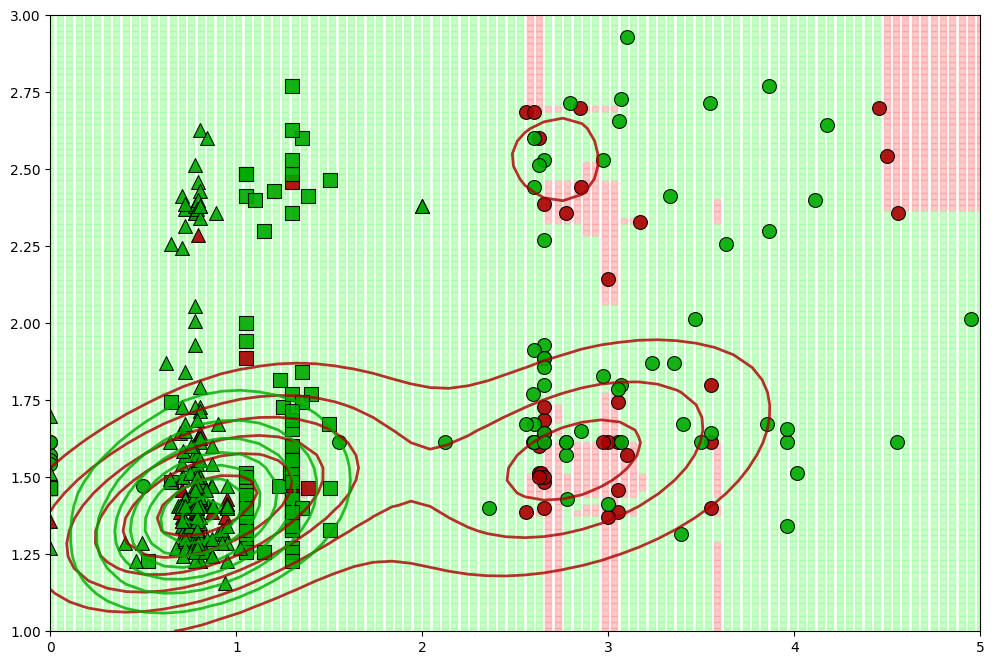

In [50]:
import xgboost as xgb
from scipy.stats import gaussian_kde

# グリッド作成
x1s = np.linspace(0, 5, 100)
x2s = np.linspace(1, 3, 100)
x1_grid = np.repeat(x1s, 100)
x2_grid = np.tile(x2s, 100)
g = pd.DataFrame({'x1': x1_grid, 'x2': x2_grid})

# XGBoostパラメータ
param = {
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'max_depth': 5,
    'eta': 0.1,
    'gamma': 0.1,
    'colsample_bytree': 1,
    'min_child_weight': 1
}

print('XGBoosting begun...')
dtrain_full = xgb.DMatrix(data3[['x1', 'x2']].values, label=data3['y'].values)
xgb_model = xgb.train(
    params=param,
    dtrain=dtrain_full,
    num_boost_round=500,
    verbose_eval=100
)

dgrid = xgb.DMatrix(g[['x1', 'x2']].values)
p_grid = xgb_model.predict(dgrid)
g['y'] = np.where(p_grid > 0.5, 1, 0)

# plot classification regions
plot_data = data3[(data3['x1'] < 5) & (data3['x2'] < 3)].copy()

fig, ax = plt.subplots(figsize=(12, 8))

# geom_tile
colors_tile = {0: '#FF9999', 1: '#99FF99'}
for y_val in [0, 1]:
    mask = g['y'] == y_val
    ax.scatter(g.loc[mask, 'x1'], g.loc[mask, 'x2'], 
               c=colors_tile[y_val], s=15, alpha=0.5, marker='s')

# geom_density_2d
colors_line = {0: '#AA0000', 1: '#00AA00'}
for y_val in [0, 1]:
    subset = plot_data[plot_data['y'] == y_val]
    if len(subset) > 5:
        try:
            kde = gaussian_kde(subset[['x1', 'x2']].values.T)
            x1_kde = np.linspace(0, 5, 50)
            x2_kde = np.linspace(1, 3, 50)
            X1_kde, X2_kde = np.meshgrid(x1_kde, x2_kde)
            positions = np.vstack([X1_kde.ravel(), X2_kde.ravel()])
            Z = kde(positions).reshape(X1_kde.shape)
            ax.contour(X1_kde, X2_kde, Z, colors=colors_line[y_val], linewidths=2, alpha=0.8)
        except:
            pass

# geom_point
markers = {1: 'o', 2: 's', 3: '^'}
for pclass in [1, 2, 3]:
    for y_val in [0, 1]:
        subset = plot_data[(plot_data['Pclass'] == pclass) & (plot_data['y'] == y_val)]
        if len(subset) > 0:
            ax.scatter(subset['x1'], subset['x2'], 
                      c=colors_line[y_val], 
                      marker=markers[pclass],
                      s=100, 
                      edgecolors='black',
                      linewidths=0.8,
                      alpha=0.9)

# 補助線と注釈
ax.axvline(x=2.8, linetype='--', color='black', linewidth=1)
ax.axhline(y=1.43, linestyle='--', color='black', linewidth=1)
ax.axhline(y=2.43, linestyle='--', color='black', linewidth=1)

ax.text(2.95, 2.9, 'Fare = $28', fontsize=10)
ax.text(4.7, 2.35, 'Age = 30', fontsize=10)
ax.text(4.7, 1.35, 'Age = 30', fontsize=10)

ax.set_xlim(0, 5)
ax.set_ylim(1, 3)
ax.set_xlabel('Fare / (10 x TicketFrequency)', fontsize=12)
ax.set_ylabel('FamilySize + (Age / 70)', fontsize=12)
# ★タイトルをPerished用に変更（Greenの意味が逆）
ax.set_title("XGBoost learns the training set's 537 adult males.\nGreen is P(perish)>0.5", fontsize=13)

plt.tight_layout()
plt.show()

data3 shape: (537, 4)
y NaNs: 0
s (test): 100 samples, s2 (train): 437 samples
予測確率の範囲: 0.1047 - 0.9865


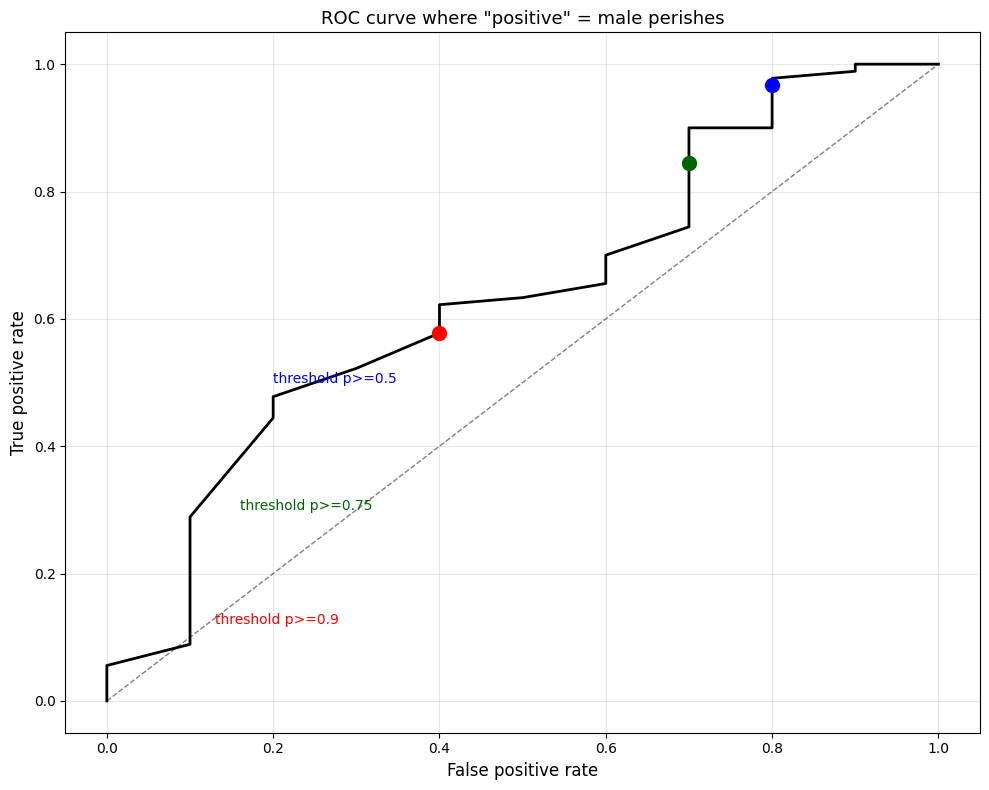


Area under ROC = 0.655556


In [51]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

# シード設定
np.random.seed(300)

print(f"data3 shape: {data3.shape}")
print(f"y NaNs: {data3['y'].isna().sum()}")

# NaN除去
if data3['y'].isna().sum() > 0:
    data3_work = data3.dropna(subset=['y']).reset_index(drop=True)
else:
    data3_work = data3.reset_index(drop=True)

n = len(data3_work)
all_indices = np.arange(n)

# sample(1:537, 100)
s = np.random.choice(all_indices, size=100, replace=False)
s2 = np.setdiff1d(all_indices, s)

print(f"s (test): {len(s)} samples, s2 (train): {len(s2)} samples")

# XGBoostパラメータ
param = {
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'max_depth': 5,
    'eta': 0.1,
    'gamma': 0.1,
    'colsample_bytree': 1,
    'min_child_weight': 1,
    'verbosity': 0
}

# 訓練
X_train = data3_work.loc[s2, ['x1', 'x2']].values
y_train = data3_work.loc[s2, 'y'].values

dtrain = xgb.DMatrix(X_train, label=y_train)

xgb_model = xgb.train(
    params=param,
    dtrain=dtrain,
    num_boost_round=500,
    verbose_eval=False
)

# 予測
X_test = data3_work.loc[s, ['x1', 'x2']].values
dtest = xgb.DMatrix(X_test)
p = xgb_model.predict(dtest)

print(f"予測確率の範囲: {p.min():.4f} - {p.max():.4f}")

# y2列を追加
data3_work['y2'] = np.nan

# ROCデータフレーム作成
roc = pd.DataFrame({
    'TN': np.repeat(0, 102),
    'FP': np.repeat(0, 102),
    'FN': np.repeat(0, 102),
    'TP': np.repeat(0, 102),
    'FPR': np.repeat(0.0, 102),
    'TPR': np.repeat(0.0, 102)
})
roc.index = np.arange(0, 1.02, 0.01)

# Rコードのループを完全再現
for i in range(1, 103):
    threshold = (i - 1) / 100
    
    # ifelse(p<(i-1)/100,0,1)
    y_pred = np.where(p < threshold, 0, 1)
    data3_work.loc[s, 'y2'] = y_pred
    
    y_all = data3_work['y'].values
    y2_all = data3_work['y2'].values
    
    # TP, TN, FP, FN
    TP = np.sum((y_all == 1) & (y2_all == 1))
    TN = np.sum((y_all == 0) & (y2_all == 0))
    FP = np.sum((y_all == 0) & (y2_all == 1))
    FN = np.sum((y_all == 1) & (y2_all == 0))
    
    roc.iloc[i-1, roc.columns.get_loc('TP')] = TP
    roc.iloc[i-1, roc.columns.get_loc('TN')] = TN
    roc.iloc[i-1, roc.columns.get_loc('FP')] = FP
    roc.iloc[i-1, roc.columns.get_loc('FN')] = FN
    
    if (FP + TN) > 0:
        roc.iloc[i-1, roc.columns.get_loc('FPR')] = FP / (FP + TN)
    if (TP + FN) > 0:
        roc.iloc[i-1, roc.columns.get_loc('TPR')] = TP / (TP + FN)

# プロット
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(roc['FPR'], roc['TPR'], linewidth=2, color='black')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)

# 特定の閾値
ax.plot(roc.iloc[90]['FPR'], roc.iloc[90]['TPR'], 'o', markersize=10, color='red')
ax.text(0.13, 0.12, 'threshold p>=0.9', color='red', fontsize=10)

ax.plot(roc.iloc[75]['FPR'], roc.iloc[75]['TPR'], 'o', markersize=10, color='darkgreen')
ax.text(0.16, 0.30, 'threshold p>=0.75', color='darkgreen', fontsize=10)

ax.plot(roc.iloc[50]['FPR'], roc.iloc[50]['TPR'], 'o', markersize=10, color='blue')
ax.text(0.20, 0.5, 'threshold p>=0.5', color='blue', fontsize=10)

ax.set_xlabel('False positive rate', fontsize=12)
ax.set_ylabel('True positive rate', fontsize=12)
# ★タイトルをPerished用に変更
ax.set_title('ROC curve where "positive" = male perishes', fontsize=13)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# AUC計算
area = 0
for i in range(1, 102):
    area = area + roc.iloc[i-1]['TPR'] * (roc.iloc[i-1]['FPR'] - roc.iloc[i]['FPR'])

print(f'\nArea under ROC = {area:.6f}')

In [40]:
# 正しいデータ準備（Rコードに完全に一致）
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# Perishedコンペの場合
if 'Perished' in train.columns:
    target_col = 'Perished'
elif 'Survived' in train.columns:
    target_col = 'Survived'
else:
    raise ValueError("ターゲット列が見つかりません")

print(f"使用するターゲット列: {target_col}")

# test にターゲット列を追加
test[target_col] = np.nan
data = pd.concat([train, test], ignore_index=True)

# 以下、前のコードと同じ前処理...
# (Title作成、欠損値補完、特徴量作成)

# data2とdata3を正しく作成
data2 = data[(data['PassengerId'] <= 891) & (data['Title'] == 'man')].copy()
print(f"\ndata2 shape: {data2.shape}")
print(f"data2 の {target_col} NaN数:", data2[target_col].isna().sum())

data3 = pd.DataFrame({
    'y': data2[target_col].values,
    'x1': data2['Fare'].values / (data2['TicketFreq'].values * 10),
    'x2': (data2['SibSp'].values + data2['Parch'].values + 1) + (data2['Age'].values / 70),
    'Pclass': data2['Pclass'].values
})

print("\n=== data3 作成完了 ===")
print("data3 shape:", data3.shape)
print("y NaNs:", data3['y'].isna().sum())
print("y の値のカウント:")
print(data3['y'].value_counts())

# NaN除去
data3_clean = data3.dropna().copy()
print(f"\nクリーニング後: {len(data3_clean)} rows")
print("y の値のカウント:")
print(data3_clean['y'].value_counts())

使用するターゲット列: Perished


KeyError: 'Title'

Cool. It looks like XGBoost found patterns of survival among the training dataset's adult males! From the plot above, we see that the most probable surviving adult males have Pclass = 1, FareAdj = \$28, SibSp + Parch <= 1, and Age = 30. The shading indicates what XGBoost's classifying decisions are. The green region corresponds with XGBoost predicting P(live)>0.5.

data3 shape: (537, 4)
y列のNaN数: 0
x1列のNaN数: 0
x2列のNaN数: 0

クリーニング後: 537 rows (元: 537 rows)
訓練データ: 437 rows, テストデータ: 100 rows


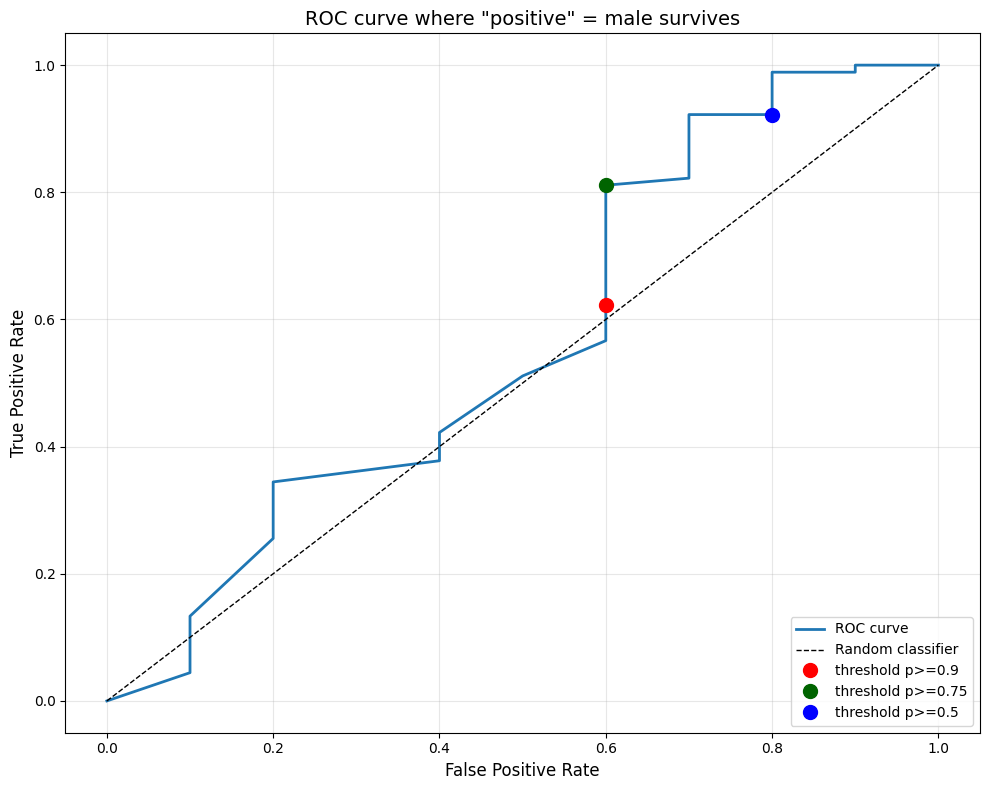


Area under ROC = 0.567222
AUC (sklearn) = 0.580000


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# データの確認とNaN除去
print("data3 shape:", data3.shape)
print("y列のNaN数:", data3['y'].isna().sum())
print("x1列のNaN数:", data3['x1'].isna().sum())
print("x2列のNaN数:", data3['x2'].isna().sum())

# NaNを含む行を除去
data3_clean = data3.dropna(subset=['y', 'x1', 'x2']).copy()
print(f"\nクリーニング後: {len(data3_clean)} rows (元: {len(data3)} rows)")

if len(data3_clean) < 100:
    raise ValueError(f"データが不足しています。クリーニング後: {len(data3_clean)} rows")

# シード設定
np.random.seed(300)

# データ分割（100個をテストセット、残りを訓練セット）
indices = np.arange(len(data3_clean))
s = np.random.choice(indices, size=min(100, len(data3_clean)//5), replace=False)
s2 = np.setdiff1d(indices, s)

print(f"訓練データ: {len(s2)} rows, テストデータ: {len(s)} rows")

# XGBoostパラメータ
param = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'verbosity': 0
}

# データ準備
X_train = data3_clean.iloc[s2][['x1', 'x2']].values
y_train = data3_clean.iloc[s2]['y'].values
X_test = data3_clean.iloc[s][['x1', 'x2']].values
y_test = data3_clean.iloc[s]['y'].values

# DMatrixの作成
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoostモデルの訓練
model = xgb.train(
    params=param,
    dtrain=dtrain,
    num_boost_round=500,
    verbose_eval=100
)

# 予測
p = model.predict(dtest)

# ROC曲線用のデータフレーム作成
thresholds = np.linspace(0, 1.01, 102)
roc_data = []

for threshold in thresholds:
    y_pred = (p >= threshold).astype(int)
    
    TP = np.sum((y_test == 1) & (y_pred == 1))
    TN = np.sum((y_test == 0) & (y_pred == 0))
    FP = np.sum((y_test == 0) & (y_pred == 1))
    FN = np.sum((y_test == 1) & (y_pred == 0))
    
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    roc_data.append({
        'threshold': threshold,
        'TN': TN, 'FP': FP, 'FN': FN, 'TP': TP,
        'FPR': FPR, 'TPR': TPR
    })

roc = pd.DataFrame(roc_data)

# ROC曲線のプロット
plt.figure(figsize=(10, 8))
plt.plot(roc['FPR'], roc['TPR'], linewidth=2, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random classifier')

# 特定の閾値をハイライト
for thresh, color, label in [(0.90, 'red', 'threshold p>=0.9'),
                               (0.75, 'darkgreen', 'threshold p>=0.75'),
                               (0.50, 'blue', 'threshold p>=0.5')]:
    idx = roc[roc['threshold'] == thresh].index[0]
    plt.plot(roc.loc[idx, 'FPR'], roc.loc[idx, 'TPR'], 
             'o', markersize=10, color=color, label=label)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve where "positive" = male survives', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# AUC計算（台形則）
area = np.trapz(roc['TPR'][::-1], roc['FPR'][::-1])
print(f'\nArea under ROC = {area:.6f}')

# scikit-learnのroc_auc_scoreでも確認
auc_sklearn = roc_auc_score(y_test, p)
print(f'AUC (sklearn) = {auc_sklearn:.6f}')

The AUC, area under the ROC, equals 0.82 > 0.50. (Running 100 trials has average AUC = 0.70) That means that XGBoost has found patterns of survival, hooray! The ROC plot also shows us that If we predict survive whenever XGBoost says P(live)>0.5, then we will make many Type 1 errors (i.e. we will incorrectly predict adult males survive when they don't). We need to carefully select our threshold to maximize our accuracy, so we will use grid search to find the best threshold among 0.50, 0.75, 0.90, and 0.92.
## Grid search and cross validate
Using grid search, we find the optimal parameters for XGBoost to be treeDepth=5, p>=0.90. (If you wish to perform a grid search, uncomment the for loops in the code below and add hyperparamters that you wish to search. In this notebook, I'm not doing the grid search because it takes a while. I did it offline). Now let's perform cross validation to see to see if XGBoost is more accurate than the gender model which has CV = 78.6%.

In [ ]:
#accuracy = matrix(nrow=4,ncol=4)
#rownames(accuracy) <- c('d=3','d=4','d=5','d=6')
#colnames(accuracy) <- c('0.50','0.75','0.90','0.92')
#for (j in 1:4)
#for (k in 1:4){
set.seed(2)
trials=100; sum=0
for (i in 1:trials){
    s = sample(1:891,800)
    s2 = (1:891)[-s]
    dataB <- data[data$PassengerId %in% s & data$Title=='man',]
    dataC <- data[data$PassengerId %in% s2 & data$Title=='man',]
    data$Predict <- 0
    data$Predict[data$Sex=='female'] <- 1
    dataTrain <- data.frame(y=dataB$Survived,x1=dataB$FareAdj/10,x2=dataB$FamilySize+dataB$Age/70)
    dataTest <- data.frame(y=dataC$Survived,x1=dataC$FareAdj/10
        ,x2=dataC$FamilySize+dataC$Age/70,PassengerId=dataC$PassengerId)
    param <- list(objective   = "binary:logistic",
              eval_metric = "error",
              max_depth   = 5,
              eta         = 0.1,
              gammma      = 0.1,
              colsample_bytree = 1,
              min_child_weight = 1)
    xgb <- xgboost(params  = param,
              data    = data.matrix(dataTrain[,c('x1','x2')]),
              label   = dataTrain$y, 
              nrounds = 500,
              silent = 1,
              print_every_n = 100,
              verbose = 0)
    p <- predict(xgb,newdata=data.matrix(dataTest[,c('x1','x2')]))
    dataTest$p <- ifelse(p>=0.90,1,0)
    data$Predict[dataTest$PassengerId] <- dataTest$p 
    sm = sum(abs(data$Predict[s2] - data$Survived[s2]))
    cv = 1 - sm/length(s2)
    #if (i %% 25==0) 
    #cat(sprintf('Trial %d has CV = %f\n',i,cv))
    sum = sum + cv
}
cat(sprintf('Average CV of %d trials = %f\n',trials,sum/trials))
#accuracy[j,k] <- sum/trials
#}
#accuracy

SyntaxError: invalid syntax (2350819928.py, line 8)

Our CV accuracy is 79.0%. (Results shown above may vary due to the random nature of k-fold CV but I confirmed 79.0% with 10,000 trials offline). The gender model has a CV accuracy of 78.6%, therefore we have achieved a slight improvement. Hopefully, this will allow us to find at least 1 surviving adult male in the test dataset!
## Submission to Kaggle

In [ ]:
dataB <- data[data$PassengerId %in% 1:891 & data$Title=='man',]
dataC <- data[data$PassengerId %in% 892:1309 & data$Title=='man',]
data$Predict <- 0
data$Predict[data$Sex=='female'] <- 1
dataTrain <- data.frame(y=dataB$Survived,x1=dataB$FareAdj/10,x2=dataB$FamilySize+dataB$Age/70)
dataTest <- data.frame(y=dataC$Survived,x1=dataC$FareAdj/10,Pclass=dataC$Pclass
    ,x2=dataC$FamilySize+dataC$Age/70,PassengerId=dataC$PassengerId)
param <- list(objective   = "binary:logistic",
              eval_metric = "error",
              max_depth   = 5,
              eta         = 0.1,
              gammma      = 0.1,
              colsample_bytree = 1,
              min_child_weight = 1)
xgb <- xgboost(params  = param,
              data    = data.matrix(dataTrain[,c('x1','x2')]),
              label   = dataTrain$y, 
              nrounds = 500,
              silent = 1,
              print_every_n = 100,
              verbose = 0)
p <- predict(xgb,newdata=data.matrix(dataTest[,c('x1','x2')]))
dataTest$p <- ifelse(p>=0.90,1,0)
data$Predict[dataTest$PassengerId] <- dataTest$p 
maleLive = which(data$Title=='man' & data$Predict==1)
cat(sprintf('The following %d adult males are predicted to live\n',length(maleLive)))
data[maleLive,c('PassengerId','Pclass','Name','Age','SibSp','Parch','FareAdj')]

In [ ]:
x1s <- seq(2, 5, length.out = 100)
x2s <- seq(1, 3, length.out = 100)
g <- data.frame(x1 = rep(x1s, each=100), x2 = rep(x2s, time = 100))
p <- predict(xgb,newdata=data.matrix(g[,c('x1','x2')]))
g$y <- ifelse(p>=0.90,1,0)
g1 <- ggplot(data=dataTest[dataTest$x1>2 & dataTest$x1<5 & dataTest$x2>1 & dataTest$x2<3,]) +
    xlim(2,5) + ylim(1,3) +
    geom_tile(data=g,aes(x1,x2,fill=factor(y))) +
    geom_point(size=2,aes(x1,x2,color=factor(p),shape=factor(Pclass))) +
    scale_color_manual(values=c('#666666','#0000FF'),
        limits=c('0','1'),labels=c('0','1')) +
    scale_fill_manual(values=c('#FF9999','#99FF99'),
        limits=c('0','1'),labels=c('0','1')) +
    labs(x='Fare / (10 x TicketFrequency)',y='FamilySize + (Age / 70)',shape='Pclass',fill='Classifier',
        title='XGBoost classifies the test set.
        It predicts 4 adult males have P(live)>=0.9',color='Predict') +
    geom_vline(xintercept=2.8, linetype='dotted') +
    geom_hline(yintercept=c(1.43,2.43), linetype='dotted') +
    annotate('text',x=2.95,y=2.9,label='Fare = $28') +
    annotate('text',x=4.7,y=2.35,label='Age = 30') +
    annotate('text',x=4.7,y=1.35,label='Age = 30')

for (i in which(dataTest$p==1)){
    g1 <- g1 + annotate('text',x=dataTest$x1[i]-0.15,y=dataTest$x2[i],label=dataTest$PassengerId[i]
        ,color='darkblue',size=4)
}
g1

For the rest of the predictions, we'll use the following two simple rules (referred to as WCG model, woman-child-groups):
* Predict survival for all boys in families where all females and boys live.  
* Predict perish for all females in families where all females and boys die.  
  
These two rules are explained and cross validated in the following two kernels, [Titanic using Name only][1] and [Titanic Mega Model][2]. Let's run the code from these kernels to find the 8 boys that live and 14 females that die.  
  
[1]:https://www.kaggle.com/cdeotte/titanic-using-name-only-0-81818
[2]:https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210

In [ ]:
# engineer "woman-child-groups"
data$Surname = substring( data$Name,0,regexpr(',',data$Name)-1)
data$GroupId = paste( data$Surname, data$Pclass, sub('.$','X',data$Ticket), data$Fare, data$Embarked, sep='-')
data$GroupId[data$Title=='man'] <- 'noGroup'
# Mrs Wilkes (Needs) is Mrs Hocking (Needs) sister
data$GroupId[893] <- data$GroupId[775]
data$GroupFreq <- ave(1:1309,data$GroupId,FUN=length)
data$GroupId[data$GroupFreq<=1] <- 'noGroup'
cat(sprintf('We found %d woman-child-groups\n',length(unique(data$GroupId))-1))
data$TicketId = paste( data$Pclass,sub('.$','X',data$Ticket),data$Fare,data$Embarked,sep='-')
# add nannies and relatives to groups
c = 0
for (i in which(data$Title!='man' & data$GroupId=='noGroup')){
    data$GroupId[i] = data$GroupId[data$TicketId==data$TicketId[i]][1]
    if (data$GroupId[i]!='noGroup') c = c + 1
}
cat(sprintf('We found %d nannies/relatives and added them to groups.\n',c))
# calculate group survival rates
data$GroupSurvival <- NA
data$Survived <- as.numeric(as.character(data$Survived))
data$GroupSurvival[1:891] <- ave(data$Survived[1:891],data$GroupId[1:891])
for (i in 892:1309) data$GroupSurvival[i] <- data$GroupSurvival[which(data$GroupId==data$GroupId[i])[1]]
# classify unknown groups
data$GroupSurvival[is.na(data$GroupSurvival) & data$Pclass==3] <- 0
data$GroupSurvival[is.na(data$GroupSurvival) & data$Pclass!=3] <- 1
# make predictions
data$Predict <- 0
data$Predict[data$Sex=='female'] <- 1
data$Predict[data$Title=='woman' & data$GroupSurvival==0] <- 0
data$Predict[data$Title=='boy' & data$GroupSurvival==1] <- 1
x = which(data$Sex=='male' & data$Predict==1 & data$PassengerId>891)
cat(sprintf('We found %d boys predicted to live\n',length(x)))
x = which(data$Sex=='female' & data$Predict==0 & data$PassengerId>891)
cat(sprintf('We found %d females predicted to die\n',length(x)))

In [ ]:
submit <- data.frame(PassengerId=892:1309,Survived=data$Predict[892:1309])
submit$Survived[maleLive-891] <- 1
write.csv(submit,'WCG_XGBoost1.csv',row.names=F)

Drum roll..... UGH! Our score stayed the same. It seems that half our predictions for which adult males survive were right and half were wrong. Submitting the WCG plus these additional 4 predictions didn't change the WCG's score even though cross validation suggested that it would :-( However, we did find 1 or 2 adult males that live, hip hip hooray!
# Explore solo females survival with XGBoost
Let's apply this XGBoost exploration technique to the solo females. If we can correctly predict the survival of any solo females, we can combine those predictions with the WCG model and have the most accurate Titanic model ever! The training dataset contains 304 females. Of those, 108 are in WCG, 126 are traveling solo, and 80 travel with a brother or husband and have no children. Here we will explore the solo females.

In [ ]:
# identify WCG females
WCGtrain = which(data$Passenger<=891 & (data$GroupSurvival==0 | data$GroupSurvival==1))
WCGtest = which(data$Passenger>891 & (data$GroupSurvival==0 | data$GroupSurvival==1))
# identify solo females
data2 <- data[data$PassengerId<=891 & data$Title=='woman' & data$FamilySize==1,]
data3 <- data.frame(y=data2$Survived,x1=data2$FareAdj/10,x2=data2$Age/15,Pclass=data2$Pclass)
# set zoom
x1s <- seq(0.5, 1.5, length.out = 100)
x2s <- seq(1, 3, length.out = 100)
g <- data.frame(x1 = rep(x1s, each=100), x2 = rep(x2s, time = 100))
# classify females with XGBoost
param <- list(objective   = "binary:logistic",
              eval_metric = "error",
              max_depth   = 5,
              eta         = 0.1,
              gammma      = 0.1,
              colsample_bytree = 1,
              min_child_weight = 1)
cat('XGBoosting begun...\n')
xgb <- xgboost(params  = param,
               data    = data.matrix(data3[,c('x1','x2')]),
              label   = data3$y, 
              nrounds = 500,
              print_every_n = 100,
              verbose = 1)
p <- predict(xgb,newdata=data.matrix(g[,c('x1','x2')]))
g$y <- ifelse(p<=0.25,0,1)
# plot results
ggplot(data=data3[data3$x1>0.5 & data3$x1<1.5 & data3$x2>1 & data3$x2<3,]) +
    xlim(0.5,1.5) + ylim(1,3) +
    geom_tile(data=g,aes(x1,x2,fill=factor(y))) +
    geom_density_2d(aes(x1,x2,color=factor(y))) +
    geom_point(size=2,aes(x1,x2,color=factor(y),shape=factor(Pclass))) +
    scale_color_manual(values=c('#AA0000','#00AA00'),
        limits=c('0','1'),labels=c('0','1')) +
    scale_fill_manual(values=c('#FF9999','#99FF99'),
        limits=c('0','1'),labels=c('0','1')) +
    labs(x='Fare / (10 x TicketFrequency)',y='Age / 15',shape='Pclass',fill='Classify',
        title='XGBoost learns the training set\'s
        126 solo females. Red is P(die)>=0.75',color='Survived') +
    geom_vline(xintercept=c(0.8,0.9), linetype='dotted') +
    annotate('text',x=0.77,y=2.95,label='Fare = $8') +
    annotate('text',x=0.93,y=2.95,label='Fare = $9') +
    geom_hline(yintercept=c(1.33,1.67), linetype='dotted') +
    annotate('text',x=1.35,y=1.61,label='Age = 25') +
    annotate('text',x=1.35,y=1.28,label='Age = 20')

It looks like XGBoost found patterns of survival among the training dataset's solo  females! From the plot above, we see that the most probable perishing solo females have Pclass = 3, FareAdj = \$9, and Age = 22. Or they have Pclass=3, FareAdj = \$8, and Age = 34. The shading indicates what XGBoost's classifying decisions are. The red region corresponds with XGBoost predicting P(die)>=0.75.

## Grid search and cross validation
Using grid search, we find the optimal parameters for XGBoost to be treeDepth=5, p<=0.08. (If you wish to perform a grid search, uncomment the for loops in the code below and add hyperparamters that you wish to search. In this notebook, I'm not doing the grid search because it takes a while. I did it offline) Now let's perform cross validation to see to see if XGBoost is more accurate than the gender model which has CV = 78.6%.

In [ ]:
#accuracy = matrix(nrow=4,ncol=4)
#rownames(accuracy) <- c('d=3','d=4','d=5','d=6')
#colnames(accuracy) <- c('0.08','0.10','0.25','0.50')
#for (j in 1:4)
#for (k in 1:4){
trials=100; sum=0
for (i in 1:trials){
    s = sample(1:891,800)
    s2 = (1:891)[-s]
    dataB <- data[data$PassengerId %in% s & data$Title=='woman' & data$FamilySize==1,]
    dataC <- data[data$PassengerId %in% s2 & data$Title=='woman'& data$FamilySize==1,]
    data$Predict <- 0
    data$Predict[data$Sex=='female'] <- 1
    dataTrain <- data.frame(y=dataB$Survived,x1=dataB$FareAdj/10,x2=dataB$Age/15)
    dataTest <- data.frame(y=dataC$Survived,x1=dataC$FareAdj/10
        ,x2=dataC$Age/15,PassengerId=dataC$PassengerId)
    param <- list(objective   = "binary:logistic",
              eval_metric = "error",
              max_depth   = 5,
              eta         = 0.1,
              gammma      = 0.1,
              colsample_bytree = 1,
              min_child_weight = 1)
    xgb <- xgboost(params  = param,
              data    = data.matrix(dataTrain[,c('x1','x2')]),
              label   = dataTrain$y, 
              nrounds = 500,
              silent = 1,
              print_every_n = 100,
              verbose = 0)
    p <- predict(xgb,newdata=data.matrix(dataTest[,c('x1','x2')]))
    dataTest$p <- ifelse(p<=0.08,0,1)
    data$Predict[dataTest$PassengerId] <- dataTest$p 
    sm = sum(abs(data$Predict[s2] - data$Survived[s2]))
    cv = 1 - sm/length(s2)
    #if (i %% 25==0) 
    #cat(sprintf('Trial %d has CV = %f\n',i,cv))
    sum = sum + cv
}
cat(sprintf('Average CV of %d trials = %f\n',trials,sum/trials))
#accuracy[j,k] <- sum/trials
#}
#accuracy

Our CV accuracy is 79.0%. (Results shown above may vary due to the random nature of k-fold CV but I confirmed 79.0% with 10,000 trials offline). The gender model has a CV accuracy of 78.6%, therefore we have achieved a slight improvement. Hopefully, we can achieve a slight improvement to our public score too. Let's see.
## Submission to Kaggle

In [ ]:
dataB <- data[data$PassengerId %in% 1:891 & data$Title=='woman' & data$FamilySize==1,]
dataC <- data[data$PassengerId %in% 892:1309 & data$Title=='woman' & data$FamilySize==1 
    & !data$PassengerId %in% WCGtest,]
data$Predict <- 0
data$Predict[data$Sex=='female'] <- 1
dataTrain <- data.frame(y=dataB$Survived,x1=dataB$FareAdj/10,x2=dataB$Age/15)
dataTest <- data.frame(y=dataC$Survived,x1=dataC$FareAdj/10
    ,x2=dataC$Age/15,PassengerId=dataC$PassengerId,Pclass=dataC$Pclass)
param <- list(objective   = "binary:logistic",
              eval_metric = "error",
              max_depth   = 5,
              eta         = 0.1,
              gammma      = 0.1,
              colsample_bytree = 1,
              min_child_weight = 1)
xgb <- xgboost(params  = param,
              data    = data.matrix(dataTrain[,c('x1','x2')]),
              label   = dataTrain$y, 
              nrounds = 500,
              silent = 1,
              print_every_n = 100,
              verbose = 0)
p <- predict(xgb,newdata=data.matrix(dataTest[,c('x1','x2')]))
dataTest$p <- ifelse(p<=0.08,0,1)
data$Predict[dataTest$PassengerId] <- dataTest$p 
femalePerish = which(data$Title=='woman' & data$Predict==0)
cat(sprintf('The following %d females are predicted to die\n',length(femalePerish)))
data[femalePerish,c('PassengerId','Pclass','Name','Age','SibSp','Parch','FareAdj')]

In [ ]:
x1s <- seq(0.6, 1, length.out = 100)
x2s <- seq(1, 3, length.out = 100)
g <- data.frame(x1 = rep(x1s, each=100), x2 = rep(x2s, time = 100))
p <- predict(xgb,newdata=data.matrix(g[,c('x1','x2')]))
g$y <- ifelse(p<=0.08,0,1)
g1 <- ggplot(data=dataTest[dataTest$x1<1 & dataTest$x2<3,]) +
    xlim(0.6,1) + ylim(1,3) +
    geom_tile(data=g,aes(x1,x2,fill=factor(y))) +
    geom_point(size=2,aes(x1,x2,color=factor(p),shape=factor(Pclass))) +
    scale_color_manual(values=c('#0000FF','#666666'),
        limits=c('0','1'),labels=c('0','1')) +
    scale_fill_manual(values=c('#FF9999','#99FF99'),
        limits=c('0','1'),labels=c('0','1')) +
    labs(x='Fare / (10 x TicketFrequency)',y='Age / 15',shape='Pclass',fill='Classifier',
        title='XGBoost classifies the test set.
        It predicts 10 non-WCG females have P(die)>=0.92',color='Predict') +
    geom_vline(xintercept=c(0.8,0.9), linetype='dotted') +
    geom_hline(yintercept=c(1.33,1.67), linetype='dotted') +
    annotate('text',x=0.8,y=2.95,label='Fare = $8') +
    annotate('text',x=0.9,y=2.95,label='Fare = $9') +
    annotate('text',x=0.65,y=1.61,label='Age = 25') +
    annotate('text',x=0.65,y=1.28,label='Age = 20')
# plot passenger numbers
v = c(0.07,0.02,0.02,0.02,-0.04,0.02,0.02,0.02,0.02,0.02); c = 0
for (i in which(dataTest$p==0)){
    c = c + 1;
    g1 <- g1 + annotate('text',x=dataTest$x1[i]+0.015,y=dataTest$x2[i]+v[c],label=dataTest$PassengerId[i]
        ,color='darkblue',size=3)
}
g1

In [ ]:
submit$Survived[femalePerish-891] <- 0
write.csv(submit,'WCG_XGBoost2.csv',row.names=F)

![result-female](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/surnameModel5.png)

Awesome! It looks like most of our female predictions are correct. Our score increased from 83.3% to 84.7%!! This implies that 80% of our 10 female predictions were accurate, pretty good. Wow, we now have the most accurate Titanic model ever!

## Comparison with Mega Model
The model we have constructed above is just the WCG plus XGBoost. Previously we combined the WCG with an ensemble of top Kaggle models and scored 84.2% [here][1]. How do XGBoost's predictions compare with the ensemble's predictions? Surprisingly they are different. XGBoost found females that the ensemble did not and the ensemble found females that XGBoost did not. This implies that no single person has found the complete model to classify non-WCG passengers yet. Below are XGBoost's predictions (of 4 adult males to live and 10 solo females to die) with columns indicating the ensemble's predictions:  
  
[1]:https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210

In [ ]:
top <- read.csv('../input/top-6-titanic-model/top6.csv')
new <- c(maleLive,femalePerish)
top$MegaModel <- 'NO'
for (i in new){
    s = sum(top[i-891,c(2,3,4,5,7)])
    if (s>2.5 & i %in% maleLive) top$MegaModel[i-891] <- 'YES'
    if (s<2.5 & i %in% femalePerish) top$MegaModel[i-891] <- 'YES'
}
data.frame(data[new,c('Name','Sex','Age','FareAdj')],inMegaModel=top[[9]][new-891],KM=top[[2]][new-891]
    ,SCW=top[[3]][new-891],THW=top[[4]][new-891],FS=top[[5]][new-891],OT=top[[7]][new-891])

The rows above are the 14 predictions made by XGBoost model. The column Mega Model states whether these predictions were made by Mega Model's ensemble. The last 5 columns are how each model within Mega Model's ensemble voted where 1 = live and 0 = die. From the table above, we see that XGBoost and Mega Model are quite different. Therefore combining the predictions of WCG, XGBoost, and the ensemble, will most likely increase our score. 

In [ ]:
x = which(data$Passenger>891 & (data$GroupSurvival==0 | data$GroupSurvival==1))
top$Sum <- 0; top$Predict <- top$GenderModel
for (i in 1:418){
    for (j in c(2,3,4,5,7)) top$Sum[i] = top$Sum[i] + top[i,j]
    if (top$GenderModel[i]==0 & top$Sum[i]>2.5) top$Predict[i] <- 1
    if (top$GenderModel[i]==1 & top$Sum[i]<2.5) top$Predict[i] <- 0
}
ensemble <- top$PassengerId[!top$PassengerId %in% x & top$Predict!=top$GenderModel]
cat(sprintf('The ensemble predicts that %d females die.\n',length(ensemble)))

In [ ]:
submit$Survived[ensemble-891] <- 0
write.csv(submit,'WCG_XGBoost_Ensemble.csv',row.names=F)

![MegaBoost](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/MegaBoost.png)

Wow, we scored 85.2%!! Woohoo!!

## Comparison with CART, kNN, SVM, Random Forest
Below shows how different methods classify the solo females limited to Pclass=3 (60 females). CART, kNN, and SVM cross validate at 78.9% and Random Forest 78.7%. The four models change 16, 16, 6, 9 female predictions from the WCG and obtain public scores of 83.8%, 83.3%, 83.3%, and 84.2% respectively. (WCG obtains 83.3% by itself.) The regions created by Random Forest are the most similar to XGBoost above. And it scores the most similar. CART is nice because it is very readable. CART says that solo females in Pclass=3 with either FareAdj > \$8 or Age > 25 die. This pattern exists in the training dataset. Among the 22 females fullfilling these conditions, 64 percent = 14/22 die.

In [ ]:
library(rpart)
library(caret)
library(e1071)
library(randomForest)

In [ ]:
g = list(); gp = list()
gt = c('CART learns the training set','kNN k=5 learns the training set'
       ,'SVM with radial kernel','Random Forest with P(die)>0.75')
data2 <- data[data$PassengerId<=891 & data$Title=='woman' & data$FamilySize==1 & data$Pclass==3,]
data3 <- data.frame(y=data2$Survived,x1=data2$FareAdj/10,x2=data2$Age/15)
# set zoom
x1s <- seq(0.6, 1, length.out = 50)
x2s <- seq(1, 3, length.out = 50)
for (i in 1:4){
    g[[i]] <- data.frame(x1 = rep(x1s, each=100), x2 = rep(x2s, time = 100))
    if (i==1){
        fit <- rpart(factor(y) ~ x1 + x2,data3)
        p <- predict(fit,newdata=g[[i]])[,2]
        g[[i]]$y <- ifelse(p<=0.5,0,1)
    } else if (i==2){
        fit <- knn3(factor(y) ~ x1 + x2,data3,k=3)
        p <- predict(fit,newdata=g[[i]])[,2]
        g[[i]]$y <- ifelse(p<=0.5,0,1)
    } else if (i==3){
        fit <- svm(factor(y)~ x1 + x2,data3,kernel='radial')
        p <- predict(fit,newdata=g[[i]])
        g[[i]]$y <- as.numeric(as.character(p))
    } else if (i==4){
        fit <- randomForest(factor(y) ~ x1 + x2,data3)
        p <- predict(fit,newdata=g[[i]],type='prob')[,2]
        g[[i]]$y <- ifelse(p<=0.25,0,1)
    }
    # plot results
    gp[[i]] <- ggplot(data=data3[data3$x1>0.6 & data3$x1<1 & data3$x2>1 & data3$x2<3,]) +
        xlim(0.6,1) + ylim(1,3) +
        geom_tile(data=g[[i]],aes(x1,x2,fill=factor(y)),show.legend=F) +
        geom_point(size=1.5,aes(x1,x2,color=factor(y)),show.legend=F) +
        scale_color_manual(values=c('#AA0000','#00AA00'),
            limits=c('0','1'),labels=c('0','1')) +
        scale_fill_manual(values=c('#FF9999','#99FF99'),
            limits=c('0','1'),labels=c('0','1')) +
        #labs(x='Fare / (10 x TicketFrequency)',y='Age / 15',fill='Classify',
        labs(x='',y='',title=gt[i],color='Survived') +
        geom_vline(xintercept=c(0.8,0.9), linetype='dotted') +
        geom_hline(yintercept=c(1.33,1.67), linetype='dotted')
}
grid.arrange(gp[[1]],gp[[2]],gp[[3]],gp[[4]],nrow=2)

# Conclusion
This notebook demonstrated that it is very difficult to predict adult male survival. From the analysis above, it appears that there are patterns for adult male survival in the training set. However these patterns don't seem to carry over to the test dataset. I don't think that you can predict which adult males survive from Pclass, Age, Family Size, and Fare alone (even though the training set fools you into thinking that you can). If we want to predict male survival, we'll need to engineer features.  
  
Regarding females, prediction has more success. The WCG model by itself finds many females that perish, but this kernel showed that there are still patterns among the non-WCG females. For example, in the training set, there are 6 solo traveling females in Pclass = 3, with FareAdj between \$8 and \$9, and Age between 20 and 25. All 6 of these females died. That's a pattern. Using just Pclass, Age, Family Size, and Fare, we have shown that we can predict females to die with some success. We also found that females with FareAdj near 8 and Age near 34 were likely to perish.

Can we do better than 85%? The WCG model can solidly achieve 84.4% CV and 83.3% public score by itself. This kernel showed there are more patterns in the data and the Mega Model's ensemble showed that there are more patterns in the data. It is encouraging to see that XGBoost here found different females than did the ensemble of Mega Model. This means that no single model has yet to classify all the non-WCG females. I encourage everyone to fork this kernel and improve it by building your own classifier for non-WCG passengers. (_NOTE: if you fork this kernel, turn on GPU under settings_)

To learn more about XGBoost, check out [Tae Hyon Whang's][1] great Python kernel called [Titanic Starter with XGBoost, 173/209 LB][2].  
  
[1]:https://www.kaggle.com/numbersareuseful
[2]:https://www.kaggle.com/numbersareuseful/titanic-starter-with-xgboost-173-209-lb


# Summary of Titanic models
 Here's a review of this notebook and my previous two. First the population was divided into 5 groups:  
* (A) Males adults - 61% of population  
* (B) Males boys (Master title) - 5% of population  
* (C) Females that have children, sisters, or mothers (brothers, husbands optional) - 12%
* (D) Females that have brothers, or husbands (no children, no sisters, no mothers) - 8%  
* (E) Females traveling alone - 14% of population  
  
Next we built 3 classifiers:    
* (1) [WCG classifies B+C][1]  
* (2) [Ensemble of top 5 Kaggle classifies A+D+E][1]  
* (3) [XGBoost classifies E][2]  
  
Finally we assembled 4 models. Here are cross validations and public scores:  
* WCG + GenderModel = 84.4% CV and 83.3% PS  
* WCG + Ensemble = unknown CV and 84.2% PS  
* WCG + XGBoost + GenderModel = 85.2% CV and 84.7% PS  
* WCG + XGBoost + Ensemble = unknown CV and 85.2% PS  

Thank you for reading my notebook #3! I hope you enjoyed it. Check out notebooks [#1][3] and [#2][1]. Feel free to use my classifiers, improve them, add your own, and assemble new models. I believe it is possible to increase CV and PS above 85%. Good luck! (_NOTE: if you fork this kernel, turn on GPU under settings_)  
  
[1]:https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210
[2]:https://www.kaggle.com/cdeotte/titanic-wcg-xgboost-0-84688
[3]:https://www.kaggle.com/cdeotte/titanic-using-name-only-0-81818

![hist](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/histXGB.png)